In [1]:
import scanpy as sc
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pyDIMM_class import DIMM
import copy

## Simulation

In [2]:
alpha_df = pd.read_csv("/home/jinpucai/Desktop/doubletNinja/SCpurity/alpha_df(1).csv", index_col=0)
alpha_1 = alpha_df['CD4T']
alpha_2 = alpha_df['CD8T']

In [3]:
from scipy.stats import dirichlet,multinomial,norm

total_umi_1 = np.exp(norm.rvs(np.log(6000),0.2, size = 1000)).astype("int32")
total_umi_2 = np.exp(norm.rvs(np.log(6000),0.2, size = 1000)).astype("int32")


# sim_alpha = gene_alpha_sim

p_vec = dirichlet.rvs(alpha_1,size = 1000)
sim_umi_1 = []
for i in range(1000):
    umi_vec = np.random.multinomial(total_umi_1[i], p_vec[i])
    sim_umi_1.append(umi_vec)
sim_umi_1 = pd.DataFrame(sim_umi_1).T

p_vec = dirichlet.rvs(alpha_2,size = 1000)
sim_umi_2 = []
for i in range(1000):
    umi_vec = np.random.multinomial(total_umi_2[i], p_vec[i])
    sim_umi_2.append(umi_vec)
sim_umi_2 = pd.DataFrame(sim_umi_2).T

sim_umi = pd.concat([sim_umi_1,sim_umi_2],axis=1)
sim_umi.columns = range(2000)

In [4]:
label = []
for i in range(1000):
    label.append("0")
for i in range(1000):
    label.append("1")


/home/jinpucai/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


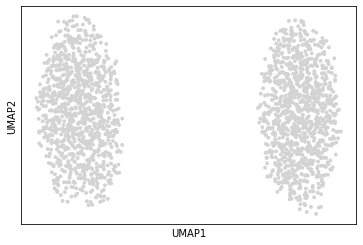

In [5]:
# adata = sc.AnnData(sim_umi_1.T)

adata = sc.AnnData(sim_umi.T)

data = copy.deepcopy(adata)
sc.pp.filter_genes(data, min_cells=3)
data.var['mt'] = data.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)

data = data[:, data.var.highly_variable]

df = adata.to_df().T.loc[data.var.index]

# data = adata.to_df()
# data = data.T[data.mean() > 0.05]
sc.tl.pca(data, svd_solver='arpack')
sc.pp.neighbors(data, n_neighbors=5, n_pcs=40)
sc.tl.umap(data)
sc.pl.umap(data)
data.obs['celltype'] = label

raw_data = copy.deepcopy(df)

In [6]:
dimm_0 = DIMM(observe_data=raw_data.to_numpy().T, n_components=2, alpha_init='kmeans')
# dimm_0 = DIMM(observe_data=CD8T_EE_df.T.to_numpy(), n_components=2, alpha_init='kmeans')
dimm_0.EM(max_round=50, max_loglik_tol= 1e-5 , max_pie_tol=1e-5)
result_0 = dimm_0.get_model()

In [7]:
dimm_label = []
delta = result_0['delta']
for i in range(delta.shape[0]):
    if(delta[i][0] > delta[i][1]):
        dimm_label.append("0")
    else:
        dimm_label.append("1")

/home/jinpucai/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical
/home/jinpucai/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'DMM' as categorical


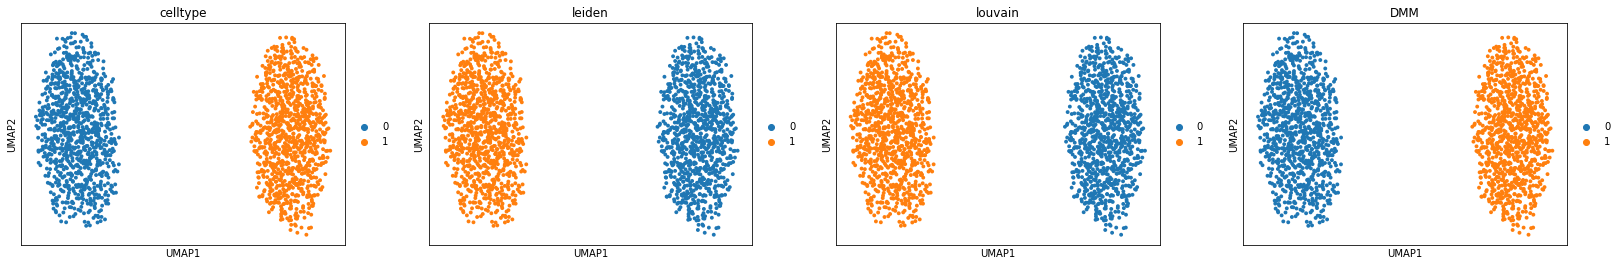

In [8]:
sc.tl.louvain(data, resolution=0.4)
sc.tl.leiden(data, resolution=0.3)
data.obs['DMM'] = dimm_label
sc.pl.umap(data,color = ['celltype','leiden','louvain','DMM'])

## Real data set

In [3]:
path = "/home/jinpucai/Desktop/JP_project/scPurity/cell_subtype/"
meta_df = pd.read_csv("/home/jinpucai/Desktop/JP_project/scPurity/Pair_celltype_data/SeuratV3/meta_data.csv", index_col = 0)
adata = sc.read_h5ad(path + "S3_CD8.h5ad")

cell_name = ['CD8 Memory_1', 'CD8 Effector_2']
cell_df = meta_df[meta_df['celltype.l2'].isin(cell_name)]

In [4]:
adata = sc.read_h5ad(path + "S3_CD8.h5ad")
adata = adata[cell_df.index,:]
# adata = adata[cell_name,:]

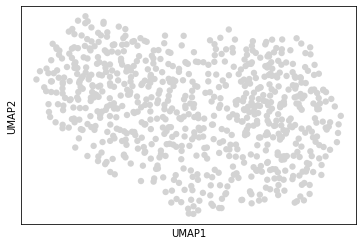

In [5]:
# adata = sc.AnnData(sim_umi_1.T)

adata = sc.AnnData(adata.to_df())

data = copy.deepcopy(adata)
sc.pp.filter_genes(data, min_cells=3)
data.var['mt'] = data.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)

data = data[:, data.var.highly_variable]

df = adata.to_df().T.loc[data.var.index]

# data = adata.to_df()
# data = data.T[data.mean() > 0.05]
sc.tl.pca(data, svd_solver='arpack')
sc.pp.neighbors(data, n_neighbors=5, n_pcs=40)
sc.tl.umap(data)
sc.pl.umap(data)
data.obs['celltype'] = meta_df.loc[data.obs.index]['celltype.l2']

raw_data = copy.deepcopy(df)

In [40]:
dimm_0 = DIMM(observe_data=raw_data.to_numpy().T, n_components=2, alpha_init='random')
# dimm_0 = DIMM(observe_data=CD8T_EE_df.T.to_numpy(), n_components=2, alpha_init='kmeans')
dimm_0.EM(max_round=200, max_loglik_tol= 0 , max_pie_tol=0)
result_0 = dimm_0.get_model()

In [42]:
dimm_label = []
delta = result_0['delta']
for i in range(delta.shape[0]):
    if(delta[i][0] > delta[i][1]):
        dimm_label.append("0")
    else:
        dimm_label.append("1")

/home/jinpucai/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'DMM' as categorical


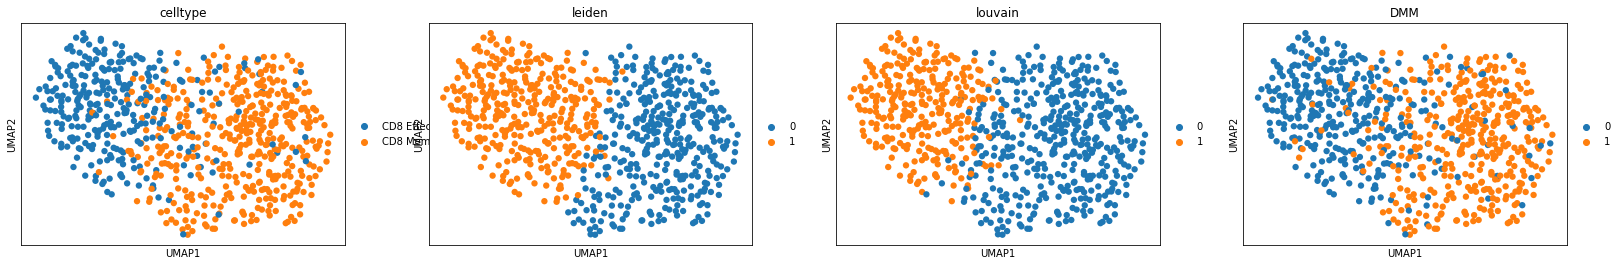

In [43]:
sc.tl.louvain(data, resolution=0.4)
sc.tl.leiden(data, resolution=0.3)
data.obs['DMM'] = dimm_label
sc.pl.umap(data,color = ['celltype','leiden','louvain','DMM'])

In [45]:
from sklearn.metrics.cluster import adjusted_rand_score
print("leiden ARI")
print(adjusted_rand_score(data.obs['celltype'],data.obs['leiden']))
print("DMM ARI")
print(adjusted_rand_score(data.obs['celltype'],data.obs['DMM']))
print("louvain ARI")
print(adjusted_rand_score(data.obs['celltype'],data.obs['louvain']))

leiden ARI
0.47484831589288146
DMM ARI
0.5437104800297253
louvain ARI
0.44546700846623566
